<a href="https://colab.research.google.com/github/tuchinhung/Quantu-ML/blob/main/Exemplo_uso_PennyLena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture 

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

In [2]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

#1. The three basic ingredients

---
Machine Learning
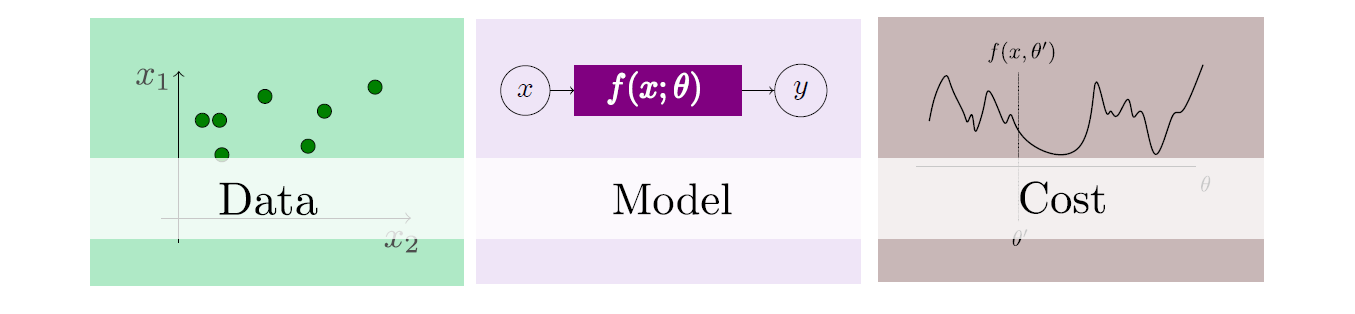

---







Use amostras de dados para construir um modelo que minimize o custo de dados não vistos.

---
Linear Models

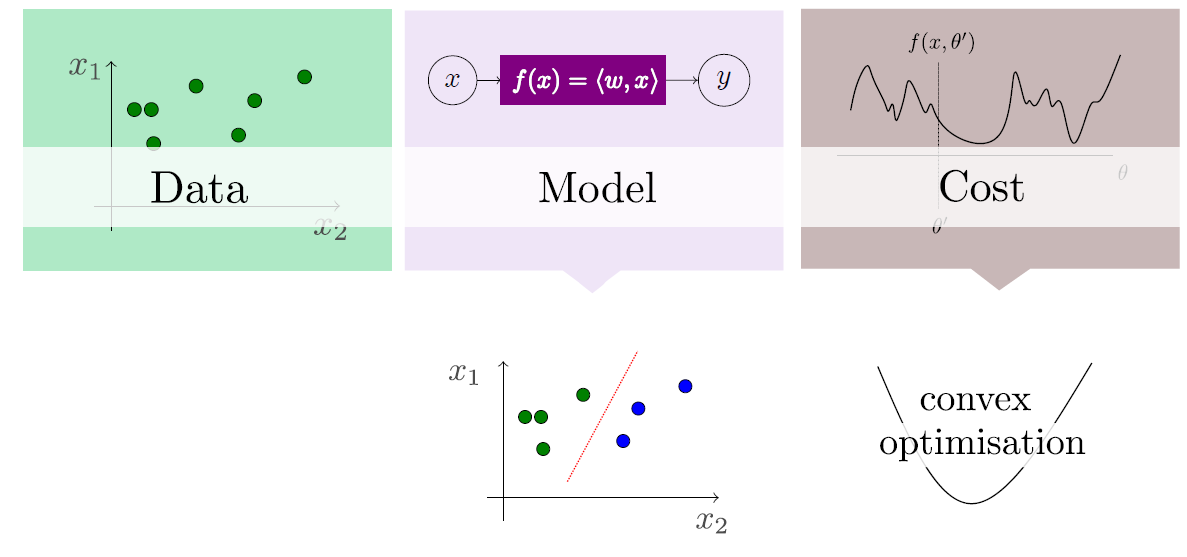
---





#Os três ingredientes básicos


Um problema de aprendizado de máquina geralmente consiste em dados, um modelo (família) e uma função de custo:

O treinamento seleciona o melhor modelo da família, minimizando o custo em um conjunto de treinamento de amostras de dados. 

Se projetarmos bem o problema de otimização, o modelo treinado também terá um custo baixo em novos conjuntos de amostras de dados que não foram usados no treinamento. Isso significa que o modelo generaliza bem.

Vamos agora criar exemplos para cada ingrediente.



# Data

Vamos criar um conjunto de dados de brinquedo bidimensional.

In [3]:
# numero aleatorio
n_samples = 100
# gera 100 numero aleatorio com distribucao normal media -1 e variacia 1, 
# e ordena por duas coluna prenche com 50 elemento de cada
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
print(X0[1:10,])
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
print(X1[1:10,])

[[-0.35231146  2.52302986]
 [-1.23415337  0.76586304]
 [ 0.57921282  1.76743473]
 [-1.46947439  1.54256004]
 [-1.46341769  0.53427025]
 [-0.75803773 -0.91328024]
 [-2.72491783  0.43771247]
 [-2.01283112  1.31424733]
 [-1.90802408 -0.4123037 ]]
[[ 0.65728548 -1.80227727]
 [ 0.83871429 -0.59594914]
 [ 2.8861859  -0.82542219]
 [ 1.25755039 -1.07444592]
 [-0.91877122 -1.02651388]
 [ 1.06023021  1.46324211]
 [ 0.80763904 -0.69845266]
 [ 0.96528823 -2.16867804]
 [ 2.14282281 -0.24806697]]


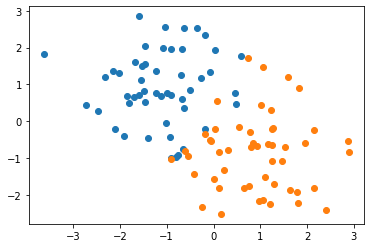

In [4]:
# Mostrando as duas variaveis em grafico em baixo:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

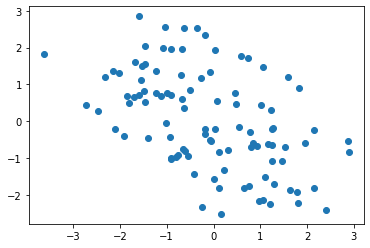

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [5]:
# concatenar variaveis X0 e X1
# np.concatenate junte-se a uma sequência de matrizes ao longo de um eixo existente.
# O eixo ao longo do qual as matrizes serão unidas. 
# Se o eixo for None, as matrizes serão niveladas antes do uso. O padrão é 0.
X = np.concatenate([X0, X1], axis=0)
plt.scatter(X[:,0], X[:,1])
plt.show()
# concatenar variaveis -1 e 1 com tamanho de 50 de cada 
# np.ones retorne um novo array de forma e tipo fornecidos, preenchido com uns.
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
print(Y)

In [6]:
np.ones(50)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True)

In [7]:
# A função zip () retorna um objeto zip, que é um iterador de tuplas 
# onde o primeiro item em cada iterador passado é pareado, 
# e então o segundo item em cada iterador passado é pareado etc.
# Se os iteradores passados tiverem comprimentos diferentes, 
# o iterador com menos itens decidirá o comprimento do novo iterador.
list1 = ("Jenny", "Christy", "Monica")
list2 = ("John", "Charles", "Mike")
lista = zip(list1, list1)
print(list(lista))

[('Jenny', 'Jenny'), ('Christy', 'Christy'), ('Monica', 'Monica')]


In [8]:
# criar a banco de dado
data = list(zip(X, Y))
data[0]

(tensor([-0.50328585,  0.8617357 ], requires_grad=True),
 tensor(-1., requires_grad=True))


# Model family

A seguir, construímos um modelo linear.

Esta função retorna o produto escalar de duas matrizes. 

Para vetores 2-D, é o equivalente à multiplicação de matrizes. Para matrizes 1-D, é o produto interno dos vetores. 

Para matrizes N-dimensionais, é um produto da soma sobre o último eixo de ae o penúltimo eixo de b.

In [9]:
# Esta função retorna o produto escalar de duas matrizes XW. 
def model(x, w):
    return np.dot(x, w)
# produto escalar de duas valores
exemplo = np.dot(3, 4)
print(exemplo)
# Nenhum dos argumentos é conjugado por complexo:
exemplo1 = np.dot([2j, 3j], [2j, 3j])
print(exemplo1)

12
(-13+0j)


In [10]:
# Vamos criar duas valores de peso w.
w = np.array([-0.2, -0.2])
print(w)
# produto escalar do primeira elemento no X0 e w
model(X0[0], w)

[-0.2 -0.2]


-0.07168997036800961

Podemos traçar o limite de decisão ou o limite no espaço de dados onde o modelo muda de uma previsão negativa para uma previsão positiva.

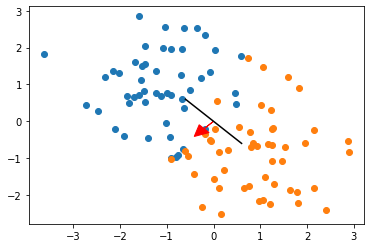

In [11]:
# construr o grafico de ponto para variaveis X0 e X1
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
# traca a reta
plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

Cost function

Primeira conclusão:

A função de perda (Função de perda) é definida em uma única amostra, uma contagem de amostra do erro.

A função de custo (função de custo) é definida em todo o conjunto de treinamento, o erro médio de todas as amostras, ou seja, a função de perda média.

A função objetivo (Object Function) é definida como: a necessidade final de otimizar a função. igual + Risco empírico Risco estrutural (ou seja, Função Custo + prazo de regularização).

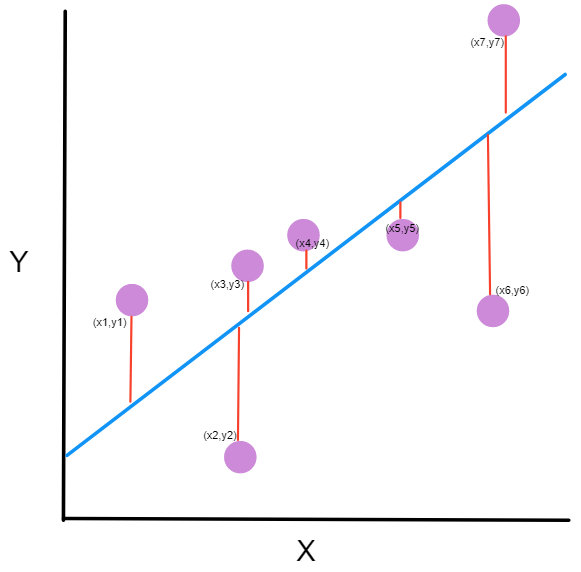

Esses termos não são muito rígidos e estão altamente relacionados. 

**A função de perda** é geralmente uma função definida em um ponto de dados, previsão e rótulo, e mede a penalidade. Por exemplo:


*   square loss(perda quadrada) -> $l(f(x_i|\theta),y_i) = \left (f(x_i|\theta)-y_i \right )^2$, usado na regressão linear.
*   hinge loss -> $l(f(x_i|\theta), y_i) = \max(0, 1-f(x_i|\theta)y_i)$, usado em SVM.
*   0/1 loss -> $l(f(x_i|\theta), y_i) = 1 \iff f(x_i|\theta) \neq y_i$, usado na análise teórica e definição de precisão.

**A função de custo** é geralmente mais geral. Pode ser uma soma de funções de perda em seu conjunto de treinamento mais alguma penalidade de complexidade do modelo (regularização).
Por exemplo:

*   Erro quadrático médio -> $MSE(\theta) = \frac{1}{N} \sum_{i=1}^N \left (f(x_i|\theta)-y_i \right )^2$.
*   Função de custo SVM -> $SVM(\theta) = \|\theta\|^2 + C \sum_{i=1}^N \xi_i$ (há restrições adicionais conectando $\xi_i$ com $C$ e com conjunto de treinamento).

**Função objetivo** é o termo mais geral para qualquer função que você otimize durante o treinamento. Por exemplo, uma probabilidade de gerar um conjunto de treinamento na abordagem de máxima verossimilhança é uma função objetivo bem definida, mas não é uma função de perda nem de custo (no entanto, você pode definir uma função de custo equivalente).

Resumindo, eu diria que:

Uma **função de perda** é uma parte de uma **função de custo** que é um tipo de **função objetivo**.

 Se tiver m dados de treinamento como estes $(x(1), y(1)), (x(2), y(2)), . . . (x(m), y(m))$.

Usamos a função de perda $L(ycap, y)$ para encontrar a perda entre $ycap$ e $y$ de um único conjunto de treinamento. 

Se quisermos encontrar a perda entre $ycap$ e $y$ de um conjunto de treinamento inteiro, usamos função de custo.

Nota: - $ycap$ significa saída de nosso modelo e $y$ significa saída esperada.



Quão bom é o modelo em um único par de treinamento de entrada-saída?

In [12]:
# uma função de perda ou função de custo é uma função que mapeia um evento ou 
# valores de uma ou mais variáveis num número real intuitivamente representando 
# algum "custo" associado ao evento. 
# Um problema de otimização procura minimizar uma função de perda.

# Função de custo é calcule [ychap - yi])^2 
# Perda de erro quadrático
def loss(ychap, yi):
    return (ychap - yi)**2
    
loss(-1, -1)


0

Vamos agora desenhar uma linha arbitrária no espaço que passa por alguns desses pontos de dados. A equação dessa linha reta seria Y = mX + b, onde m é a inclinação eb é sua interceptação no eixo Y.

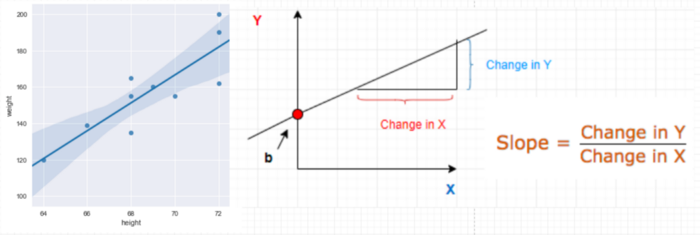





Previsões: Dado um conjunto conhecido de entradas e suas saídas correspondentes, um modelo de aprendizado de máquina tenta fazer algumas previsões para um novo conjunto de entradas.

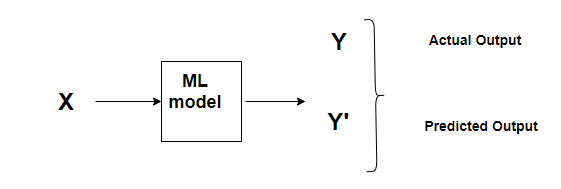


O erro seria a diferença entre as duas previsões.

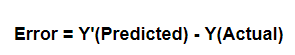

Isso se relaciona com a ideia de uma função de custo ou função de perda.

Uma função de custo basicamente nos diz "quão bom" nosso modelo é em fazer previsões para um determinado valor de m e b.

Digamos que haja um total de 'N' pontos no conjunto de dados e, para todos esses 'N' pontos de dados, queremos minimizar o erro. Portanto, a função de custo seria o erro quadrático total, ou seja,

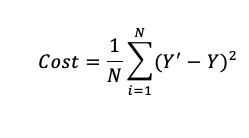


Qual é a perda média em um conjunto de dados de vários pares?

In [13]:
# função da perda media / erro quadrático médio 
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w) # a indice predicao é função do produto escalar (x, w)
        c += loss(prediction, y) # Função de perda de erro quadrático
    return c/len(data) # Função da perda media


#2. Automatic computation of gradients

O gradiente descendente é um dos algoritmos mais populares para realizar a otimização e, de longe, a maneira mais comum de otimizar redes neurais. É um algoritmo de otimização iterativo usado para encontrar o valor mínimo para uma função.

No cálculo vetorial o gradiente (ou vetor gradiente) é um vetor que indica o sentido e a direção na qual, por deslocamento a partir do ponto especificado, obtém-se o maior incremento possível no valor de uma grandeza a partir da qual se define um campo escalar para o espaço em consideração.

Cálculo automático de gradientes

Como importamos a versão numpy do PennyLane, agora podemos calcular gradientes da perda média em relação aos pesos!

In [14]:
# calcular a funcao perda media pelo peso w e data
w = np.array([0.1, -0.1])
average_loss(w, data)

0.6705617111275896

In [15]:
# Retorna o gradiente como uma função que pode ser chamada de (funções de) QNodes.
# A função que retorna o gradiente da função de entrada em relação aos argumentos diferenciáveis
# grad(fun, argnum=None)
# func (função) - um QNode simples ou uma função Python que contém uma combinação de nós quânticos e clássicos
# argnum (int, list (int), None) - Qual (is) argumento (s) o gradiente deve ser considerado. 
# Por padrão, os próprios argumentos são usados para determinar a diferenciabilidade, examinando a propriedade requires_grad. 
# Fornecer esse argumento de palavra-chave substitui esse comportamento, 
# permitindo que a diferenciabilidade do argumento seja definida manualmente para a função de gradiente retornada.
# Usando a valor da perda media anterior
gradient_fn = qml.grad(average_loss, argnum=0)
# gradiente descendente pelo peso w e data
gradient_fn(w, data)

array([-1.50619253,  1.25442995])

In [16]:
# valor da perda media pelo gradiente descendente
w_new = w - 0.05*gradient_fn(w, data)
average_loss(w_new, data)

0.5039476500948409

#3. Training with gradient descent

O método do gradiente é um método numérico usado em otimização. Para encontrar um mínimo de uma função usa-se um esquema iterativo, onde em cada passo se toma a direção do gradiente, que corresponde à direção de declive máximo.

Juntando tudo, podemos treinar o modelo linear.

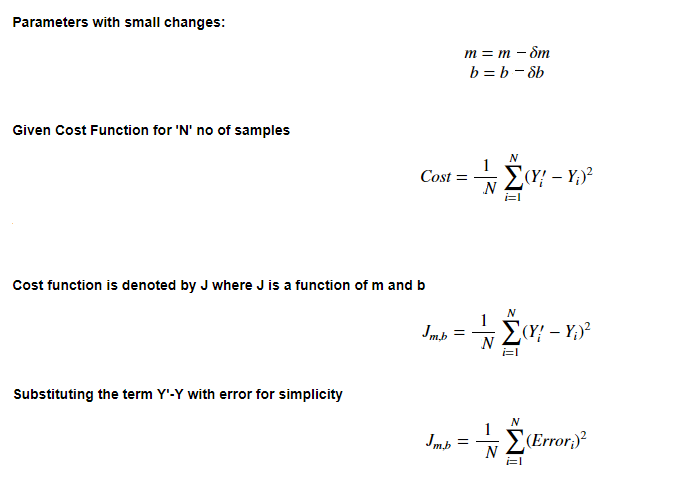

In [25]:
# model y = wX + b
def model_with_bias(x, w, b):
    return np.dot(x, w) + b

# Cost = 1/N * sum(ychap - yi)^2
def average_loss(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

In [28]:
# calcule a gradiente para peso de w e b
gradient_fn_w = qml.grad(average_loss, argnum=0)

gradient_fn_b = qml.grad(average_loss, argnum=1)


In [27]:
# sortia 2 valores peso w inicial aleatorio
w_init = np.random.random(size=(2,))
print(w_init)
# sortia outra 2 peso w
w = np.array(w_init)
print(w)
b = np.array(0.0) # start with zero bias
print(b)

[0.87737307 0.74076862]
[0.87737307 0.74076862]
0.0


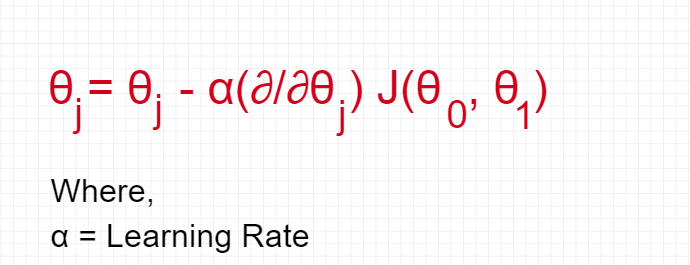

In [ ]:
# taxa de aprendizagem alpha = 0.05
# perda meida sobre o peso novo ate 15 fezes
for i in range(15):
    w_new = w - 0.05*gradient_fn_w(w, b, data)
    b_new = b - 0.05*gradient_fn_b(w, b, data)
    print(average_loss(w_new, b_new, data))
    w = w_new
    b = b_new
    ave_loss_class = average_loss(w_new, b_new, data)

1.3488121477541597
1.0997874532292236
0.9256009051357554
0.7985621334225754
0.7026027773731548
0.628100877849561
0.5690671951101229
0.521605195517599
0.4830597156035511
0.4515395126151164
0.42564403878458035
0.40430277479729804
0.3866774171010441
0.3720998180223305
0.3600307816347295


Copie e cole o código do bloco de notas anterior aqui e substitua o modelo clássico pela função quantum_model. Isso permitirá que você treine o modelo!

Adicione um termo de polarização ao modelo quântico.


In [ ]:
import pennylane as qml
from pennylane import numpy as np

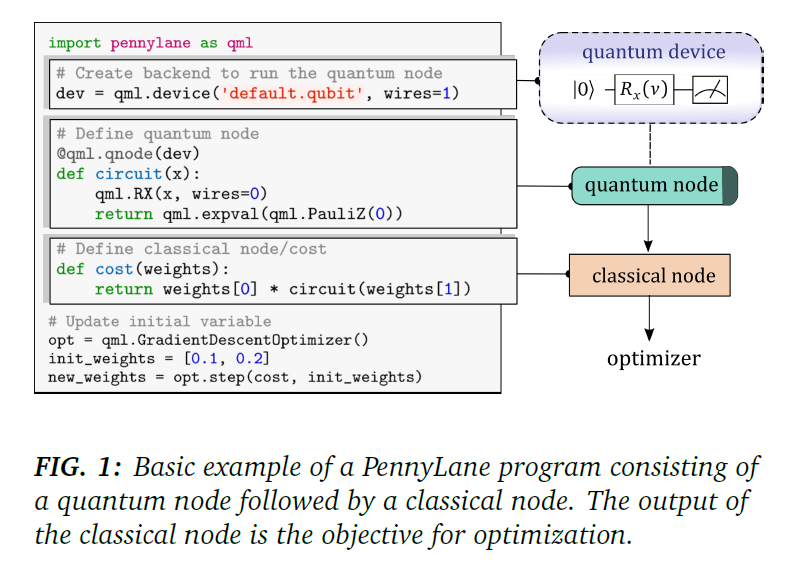

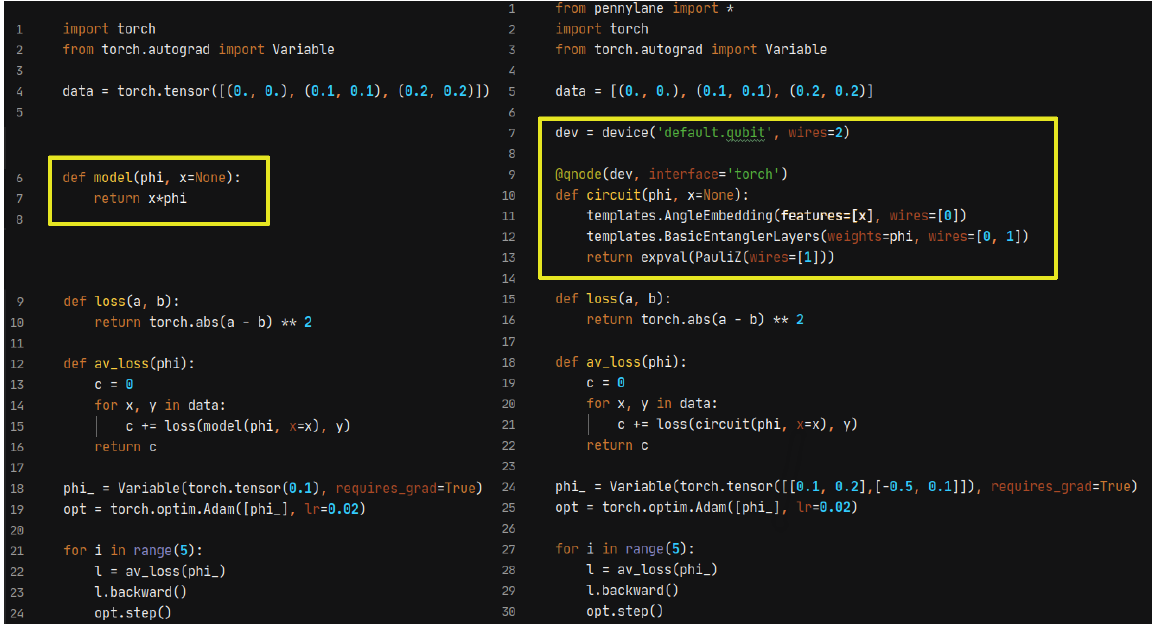

Em PennyLane, um nó quântico é uma unidade computacional que envolve a construção, avaliação, pré e pós-processamento de cálculos quânticos.

Um nó quântico consiste em uma função quântica que define um circuito, bem como um dispositivo no qual ele é executado.

Aqui, usaremos o dispositivo default.qubit embutido.

In [ ]:
dev = qml.device('default.qubit', wires=2)

qml.templates.AngleEmbedding(x, wires=[0, 1])


AngleEmbedding(features, wires, rotation='X')

Codifica N recursos nos ângulos de rotação de n qubits, onde N ≤ n.

As rotações podem ser escolhidas como portas RX, RY ou RZ, conforme definido pelo parâmetro de rotação:

rotação = 'X' usa os recursos como ângulos de rotações RX

rotação = 'Y' usa os recursos como ângulos de rotações RY

rotação = 'Z' usa os recursos como ângulos de rotações RZ

O comprimento dos recursos deve ser menor ou igual ao número de qubits. Se houver menos entradas em recursos do que rotações, o circuito não aplica as portas de rotação restantes.

Parâmetros
features (matriz) - matriz de entrada de forma (N,), onde N é o número de recursos de entrada a serem incorporados, com N ≤ n,

wires(Iteráveis) - interaveis nos quais o modelo atua. Aceita um iterável de números ou strings, ou um objeto Wires.
rotation (str) - Tipo de rotações usadas

qml.templates.BasicEntanglerLayers(w, wires=[0, 1])

BasicEntanglerLayers(weights, wires, rotation=None)

*Camadas* que consistem em rotações de qubit único de um parâmetro em cada qubit, seguido por uma cadeia fechada ou anel de portas CNOT.

O anel das portas CNOT conecta cada qubit com seu vizinho, com o último qubit sendo considerado como vizinho do primeiro qubit.

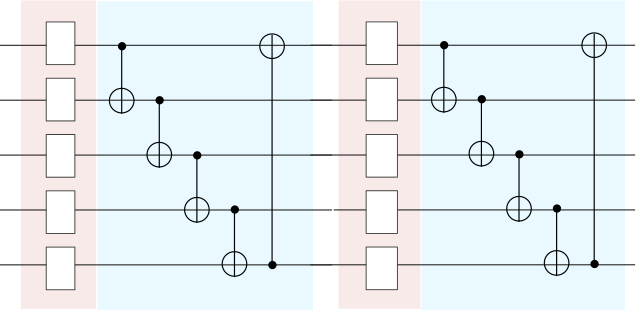

O número de camadas L é determinado pela primeira dimensão dos pesos dos argumentos. Ao usar um único fio, o modelo aplica apenas as portas de qubit simples em cada camada.

In [ ]:
@qml.qnode(dev)
def quantum_model(x, w):

    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=0)) # Valor de expectativa do observável fornecido.
    # o circuito a seguir retorna o valor esperado do operador Pauli Z observável no fio 1

# definir funcao gradiente
gradient_fn = qml.grad(quantum_model)


In [ ]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 

X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))

def model_with_bias(x, w, b):
    return quantum_model(x, w) + b

def loss(a, b):
    return (a - b)**2

def average_loss(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn_w = qml.grad(average_loss, argnum=0)
gradient_fn_b = qml.grad(average_loss, argnum=1)

w_init = np.random.random(size=(3, 2))
w = np.array(w_init)
b = np.array(0.0) # start with zero bias

for i in range(15):
    w_new = w - 0.05*gradient_fn_w(w, b, data)
    b_new = b - 0.05*gradient_fn_b(w, b, data)

    print(average_loss(w_new, b_new, data))
    w = w_new
    b = b_new
    ave_loss_qml = average_loss(w_new, b_new, data)


2.0464340361358504
1.9227268422996124
1.793324509572079
1.6626295783405902
1.5349650948728795
1.413989237854602
1.3023342395272197
1.2015175631378774
1.112068343609716
1.0337659215252781
0.9658979211571941
0.9074818942799466
0.8574297021750036
0.8146560635013778
0.7781424226375276


Substitua a etapa de otimização codificada manualmente por um otimizador PennyLane nativo.



In [ ]:
opt = qml.GradientDescentOptimizer(0.05)
for i in range(15):
    
    ([w, b], cst) = opt.step_and_cost(lambda w_, b_: average_loss(w_, b_, data), w, b)
    print(cst)
    opt_cst = cst

0.7781424226375276
0.7469690978684178
0.7203268302299429
0.6975160029536664
0.6779391603068804
0.6610904146226068
0.6465439003316876
0.6339424920094128
0.6229874113890239
0.6134289911673889
0.6050586574921772
0.5977020812643621
0.5912133936167424
0.5854703395618561
0.5803702412290943


In [ ]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

Find the local minima of the function y=(x+5)² starting from the point x=3

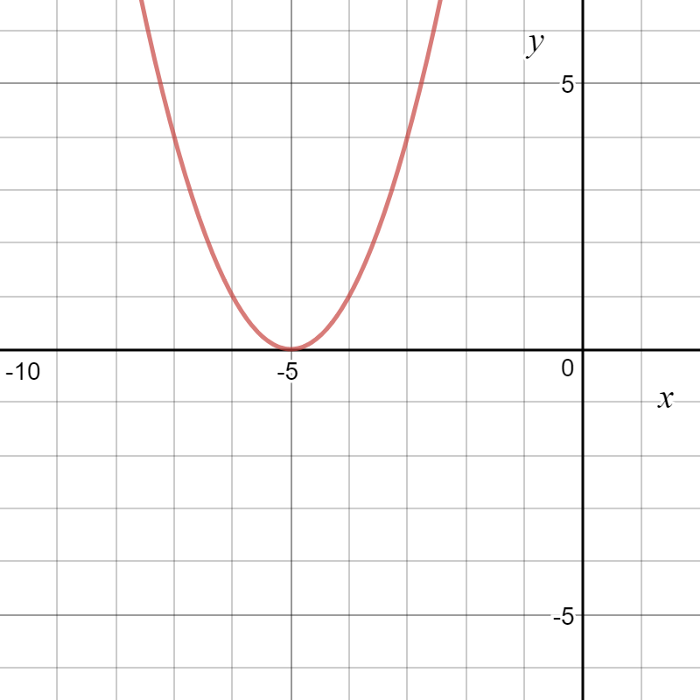

Solução: sabemos a resposta apenas olhando para o gráfico. y = (x + 5)² atinge seu valor mínimo quando x = -5 (ou seja, quando x = -5, y = 0). Portanto, x = -5 são os mínimos locais e globais da função.

Agora, vamos ver como obter o mesmo numericamente usando gradiente descendente.

Etapa 1: inicializar x = 3. Em seguida, encontre o gradiente da função, dy/dx = 2 * (x + 5).

Etapa 2: Mova na direção do negativo do gradiente (por quê?). Mas espere, quanto mover? Para isso, exigimos uma taxa de aprendizado. Vamos supor a taxa de aprendizagem → 0,01

Etapa 3: vamos realizar 2 iterações de gradiente descendente

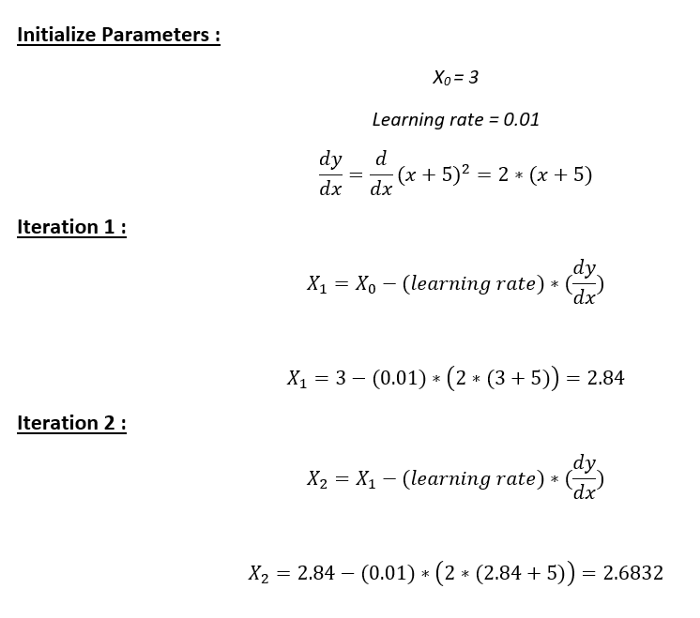

Etapa 4: Podemos observar que o valor de X está diminuindo lentamente e deve convergir para -5 (os mínimos locais). No entanto, quantas iterações devemos realizar?


Vamos definir uma variável de precisão em nosso algoritmo que calcula a diferença entre dois valores “x” consecutivos. Se a diferença entre os valores x de 2 iterações consecutivas for menor do que a precisão que definimos, pare o algoritmo!

In [23]:
cur_x = 3 # The algorithm starts at x=3
rate = 0.01 # Learning rate
precision = 0.000001 #This tells us when to stop the algorithm
previous_step_size = 1 #
max_iters = 200 # maximum number of iterations
iters = 0 #iteration counter
df = lambda x: 2*(x+5) #Gradient of our function 

In [24]:
while previous_step_size > precision and iters < max_iters:
    prev_x = cur_x #Store current x value in prev_x
    cur_x = cur_x - rate * df(prev_x) #Grad descent
    previous_step_size = abs(cur_x - prev_x) #Change in x
    iters = iters+1 #iteration count
    print("Iteration",iters,"\nX value is",cur_x) #Print iterations
    
print("The local minimum occurs at", cur_x)

Iteration 1 
X value is 2.84
Iteration 2 
X value is 2.6832
Iteration 3 
X value is 2.529536
Iteration 4 
X value is 2.37894528
Iteration 5 
X value is 2.2313663744
Iteration 6 
X value is 2.0867390469119997
Iteration 7 
X value is 1.9450042659737599
Iteration 8 
X value is 1.8061041806542846
Iteration 9 
X value is 1.669982097041199
Iteration 10 
X value is 1.5365824551003748
Iteration 11 
X value is 1.4058508059983674
Iteration 12 
X value is 1.2777337898784
Iteration 13 
X value is 1.152179114080832
Iteration 14 
X value is 1.0291355317992152
Iteration 15 
X value is 0.9085528211632309
Iteration 16 
X value is 0.7903817647399662
Iteration 17 
X value is 0.6745741294451669
Iteration 18 
X value is 0.5610826468562635
Iteration 19 
X value is 0.44986099391913825
Iteration 20 
X value is 0.3408637740407555
Iteration 21 
X value is 0.23404649855994042
Iteration 22 
X value is 0.1293655685887416
Iteration 23 
X value is 0.026778257216966764
Iteration 24 
X value is -0.07375730792737258
It